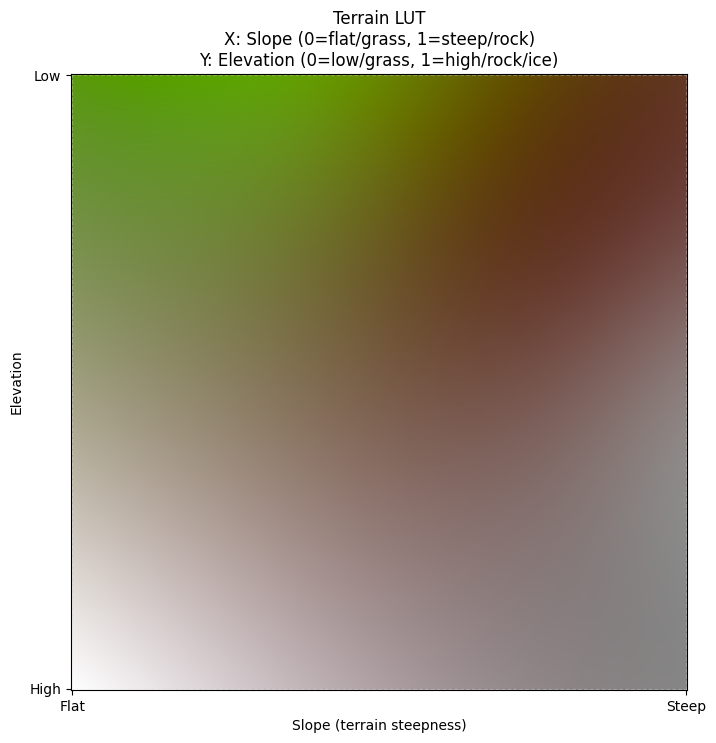

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from scipy.interpolate import Rbf
import colour

def sRGB_to_Oklab(srgb):
    srgb_normalized = np.asarray(srgb) / 255.0
    oklab = colour.convert(srgb_normalized, 'sRGB', 'Oklab')
    return oklab

def Oklab_to_sRGB(oklab):
    srgb = colour.convert(oklab, 'Oklab', 'sRGB')
    srgb = np.clip(srgb, 0, 1) * 255
    return srgb.astype(np.uint8)

lut_size = 256
grid_x, grid_y = np.meshgrid(np.linspace(0, 1, lut_size), np.linspace(0, 1, lut_size))

# Define known points with their positions (normalized between 0 and 1) and colors
known_points = [
    # {'pos': (0, 0), 'color': [90, 156, 64]},        # Grass
    {'pos': (0, 0), 'color': [90, 155, 11]},        # Grass
    {'pos': (0.4, 0.0), 'color': [100, 155, 0]},        # Grass
    {'pos': (0, 0.5), 'color': [160, 160, 128]},      # Transition to barren
    {'pos': (0, 1), 'color': [255, 255, 255]},      # Exposed rock/ice
    {'pos': (1, 0), 'color': [99, 56, 36]},         # Dirt/rock
    {'pos': (0.75, 0.3), 'color': [99, 56, 36]},         # Dirt/rock
    {'pos': (1, 0.5), 'color': [139, 125, 123]},  # Bare rock
    {'pos': (1, 1), 'color': [135, 135, 135]},    # Grey rock
    #{'pos': (0.5, 0.5), 'color': [0, 0, 255]},     # Additional arbitrary point
    # Add more arbitrary points as needed
]

# Extract positions and convert colors to Oklab
points = np.array([point['pos'] for point in known_points])
colors = np.array([sRGB_to_Oklab(point['color']) for point in known_points])

rbf_L = Rbf(points[:, 0], points[:, 1], colors[:, 0], function='multiquadric')
rbf_a = Rbf(points[:, 0], points[:, 1], colors[:, 1], function='multiquadric')
rbf_b = Rbf(points[:, 0], points[:, 1], colors[:, 2], function='multiquadric')

lut_L = rbf_L(grid_x, grid_y)
lut_a = rbf_a(grid_x, grid_y)
lut_b = rbf_b(grid_x, grid_y)

lut_oklab = np.stack((lut_L, lut_a, lut_b), axis=-1)
lut_oklab_flat = lut_oklab.reshape(-1, 3)
lut_srgb_flat = Oklab_to_sRGB(lut_oklab_flat)
lut_rgb = lut_srgb_flat.reshape(lut_size, lut_size, 3)

plt.figure(figsize=(8, 8))
plt.imshow(lut_rgb)
plt.title("Terrain LUT\nX: Slope (0=flat/grass, 1=steep/rock)\nY: Elevation (0=low/grass, 1=high/rock/ice)")
plt.xlabel("Slope (terrain steepness)")
plt.ylabel("Elevation")
plt.xticks([0, lut_size-1], ["Flat", "Steep"])
plt.yticks([0, lut_size-1], ["Low", "High"])
plt.grid(True, color='white', linestyle='--', alpha=0.3)
plt.show()

import json

# Convert lut_rgb to a nested list
lut_rgb_list = lut_rgb.tolist()

# Save to JSON file
with open("lut_rgb.json", "w") as f:
    json.dump(lut_rgb_list, f)

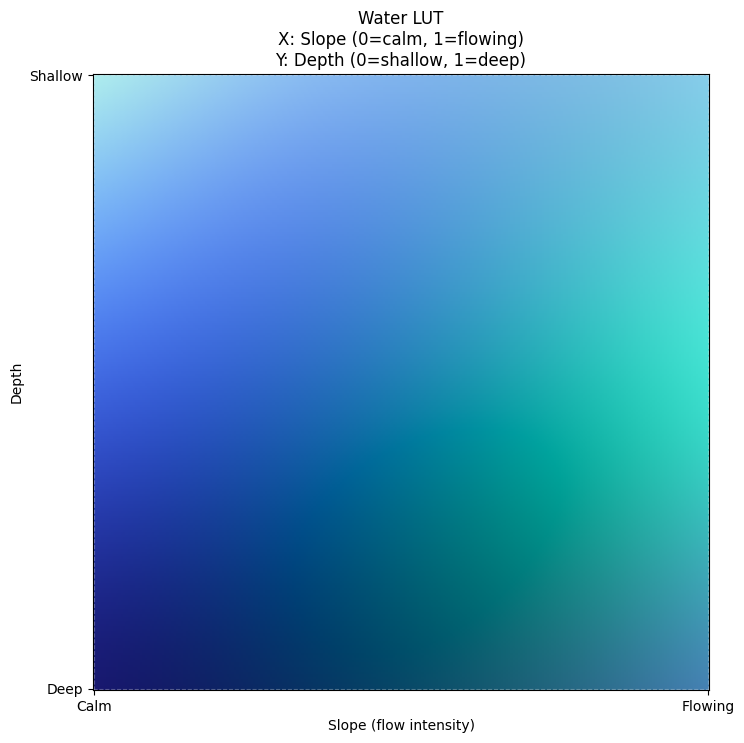

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import Rbf
import colour

def sRGB_to_Oklab(srgb):
    srgb_normalized = np.asarray(srgb) / 255.0
    oklab = colour.convert(srgb_normalized, 'sRGB', 'Oklab')
    return oklab

def Oklab_to_sRGB(oklab):
    srgb = colour.convert(oklab, 'Oklab', 'sRGB')
    srgb = np.clip(srgb, 0, 1) * 255
    return srgb.astype(np.uint8)

# Water LUT parameters
lut_size = 256
grid_x, grid_y = np.meshgrid(np.linspace(0, 1, lut_size), np.linspace(0, 1, lut_size))

# Define known points for water colors
known_points = [
    # Still water (X=0)
    {'pos': (0, 0), 'color': [175, 238, 238]},  # Shallow & calm (light cyan)
    {'pos': (0, 0.5), 'color': [65, 105, 225]},  # Mid-depth (royal blue)
    {'pos': (0, 1), 'color': [25, 25, 112]},    # Deep & calm (midnight blue)

    # Flowing water (X=1)
    {'pos': (1, 0), 'color': [135, 206, 235]},  # Shallow & flowing (sky blue)
    {'pos': (1, 0.5), 'color': [64, 224, 208]},  # Mid-flow (teal)
    {'pos': (1, 1), 'color': [70, 130, 180]},    # Deep & flowing (steel blue)

    # Intermediate points for smoother blends
    {'pos': (0.3, 0.2), 'color': [100, 149, 237]},  # Cornflower blue
    {'pos': (0.7, 0.8), 'color': [0, 128, 128]},    # Deeper teal
]

# Extract positions and convert colors to Oklab
points = np.array([point['pos'] for point in known_points])
colors = np.array([sRGB_to_Oklab(point['color']) for point in known_points])

# Interpolate using RBF
rbf_L = Rbf(points[:, 0], points[:, 1], colors[:, 0], function='multiquadric')
rbf_a = Rbf(points[:, 0], points[:, 1], colors[:, 1], function='multiquadric')
rbf_b = Rbf(points[:, 0], points[:, 1], colors[:, 2], function='multiquadric')

lut_L = rbf_L(grid_x, grid_y)
lut_a = rbf_a(grid_x, grid_y)
lut_b = rbf_b(grid_x, grid_y)

# Combine and convert back to sRGB
lut_oklab = np.stack((lut_L, lut_a, lut_b), axis=-1)
lut_oklab_flat = lut_oklab.reshape(-1, 3)
lut_srgb_flat = Oklab_to_sRGB(lut_oklab_flat)
water_lut_rgb = lut_srgb_flat.reshape(lut_size, lut_size, 3)

# Plot the water LUT
plt.figure(figsize=(8, 8))
plt.imshow(water_lut_rgb)
plt.title("Water LUT\nX: Slope (0=calm, 1=flowing)\nY: Depth (0=shallow, 1=deep)")
plt.xlabel("Slope (flow intensity)")
plt.ylabel("Depth")
plt.xticks([0, lut_size-1], ["Calm", "Flowing"])
plt.yticks([0, lut_size-1], ["Shallow", "Deep"])
plt.grid(True, color='white', linestyle='--', alpha=0.3)
plt.show()

# Save to JSON
import json
with open("water_lut_rgb.json", "w") as f:
    json.dump(water_lut_rgb.tolist(), f)